In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg

In [2]:
pd.set_option('max_rows', 7)
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 4

In [3]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
X = data['X']
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
y = data['y']
y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

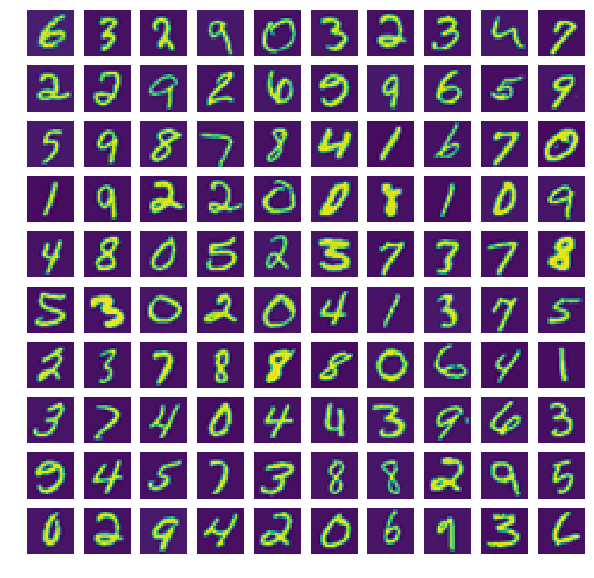

In [6]:
FIG_SIZE = 10
_, axarr = plt.subplots(FIG_SIZE, FIG_SIZE, figsize=(FIG_SIZE, FIG_SIZE))
for i in range(FIG_SIZE):
    for j in range(FIG_SIZE):
        random_digit = X[np.random.randint(X.shape[0])]
        axarr[i, j].imshow(random_digit.reshape((20, 20), order='F'))
        axarr[i, j].axis('off')

In [7]:
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print(f"Theta shapes: theta1={theta1.shape}, theta2={theta2.shape}")

Theta shapes: theta1=(25, 401), theta2=(10, 26)


In [8]:
#unroll params
#ravel "F"- flatten thetas in column-major
nn_params = np.hstack((theta1.ravel(order='F'), 
                       theta2.ravel(order='F')))
nn_params

array([-0.02256239, -0.09838113,  0.11615605, ..., -2.11014003,
       -2.1319153 , -1.32752042])

In [9]:
m, n = X.shape
ones = np.ones((m, 1))
m

5000

In [10]:
#neural network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_of_labels = 10
lmbda = 1

In [11]:
#one hot encoding
y_dummies = pd.get_dummies(y.flatten())
y_dummies

,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4997,0,0,0,0,0,0,0,0,1,0
4998,0,0,0,0,0,0,0,0,1,0
4999,0,0,0,0,0,0,0,0,1,0


In [12]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [25]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_of_labels, X, y, lmbda):
    
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                    (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],
                        (num_of_labels, hidden_layer_size+1), 'F')
    
    
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)

    inner_sum1 = np.multiply(y_dummies, np.log(h))
    inner_sum2 = np.multiply(1-y_dummies, np.log(1-h))
    inner_sums = np.sum(inner_sum1 + inner_sum2)

    reg_sum1 = np.sum(np.sum(np.power(theta1[:,1:], 2), axis=1))
    reg_sum2 = np.sum(np.sum(np.power(theta2[:,1:], 2), axis=1))
    reg_sums = reg_sum1 + reg_sum2

    regularization = (lmbda/(2*m)) * reg_sums
    J = np.sum(inner_sums/(-m)) + regularization

    return J


#expected 0.383770
x = 0.38376985909092354
nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_of_labels, X, y, lmbda)

0.38376985909092354

## Backpropagation

In [50]:
def sigmoidGrad(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

In [51]:
#test: For large values (both positive and negative) 
#of z, the gradient should be close to 0. 
#When z = 0, the gradi- ent should be exactly 0.25. 
#Your code should also work with vectors and matrices. 
#For a matrix, your function should perform the sigmoid 
#gradient function on every element.
sigmoidGrad(0)

0.25

In [52]:
sigmoidGrad(99)

0.0

In [39]:
#Random initialization for symmetry breaking
epsilon = 0.12

!["selecting epsilon"](selecting_epsilon.png "Epsilon")

In [40]:
def randomWeights(L_in, L_out):
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon - epsilon

In [41]:
theta1_initial = randomWeights(input_layer_size, hidden_layer_size)
theta2_initial = randomWeights(hidden_layer_size, num_of_labels)
theta1_initial

array([[-0.06475263, -0.02610655, -0.00823968, ...,  0.0548879 ,
        -0.10509819,  0.00100733],
       [ 0.06491989, -0.02448568,  0.08385379, ...,  0.07585785,
         0.07144452,  0.02110941],
       [-0.09404978,  0.02560036,  0.0516682 , ...,  0.04548333,
        -0.10330593,  0.0590647 ],
       ...,
       [-0.06155019, -0.09483534,  0.0985391 , ...,  0.00114851,
        -0.05265008, -0.08506748],
       [-0.02912819, -0.01929433,  0.07431545, ..., -0.03005754,
        -0.08531482, -0.09503856],
       [-0.07087101, -0.01854109,  0.04559562, ...,  0.04022976,
        -0.0857053 ,  0.03597472]])

In [42]:
theta2_initial

array([[-0.09227764, -0.06323994,  0.06381914,  0.11412532,  0.00960168,
         0.110125  ,  0.01832747, -0.02854756, -0.1179618 , -0.10105427,
         0.06135263, -0.04794977, -0.06140201,  0.05106832, -0.1032937 ,
        -0.02662682, -0.03383613, -0.06929648, -0.08771421, -0.10367316,
         0.05041768, -0.00912621,  0.11120031, -0.00410047, -0.07301748,
        -0.06984651],
       [ 0.10800885,  0.09783729, -0.06728672, -0.02502919, -0.08734527,
         0.03382899, -0.08799847, -0.05403173,  0.05838896,  0.00666077,
         0.097234  ,  0.10237816,  0.05372239,  0.02743405, -0.00474621,
        -0.11327837, -0.00313827, -0.07983016,  0.01976285,  0.11678041,
         0.02870617,  0.00786497, -0.11049601,  0.02336341, -0.05118146,
        -0.0320735 ],
       [ 0.05578441, -0.03578601,  0.01982438,  0.08790389,  0.09664024,
        -0.11729763, -0.08781038,  0.0948253 , -0.02067718,  0.09736963,
        -0.08563478,  0.0064637 , -0.04649655, -0.03919976,  0.07615581,
       

In [43]:
#unroll params
nn_initial_params = np.hstack((theta1_initial.ravel(order='F'),
                               theta2_initial.ravel(order='F')))
nn_initial_params

array([-0.06475263,  0.06491989, -0.09404978, ...,  0.04725318,
       -0.04161534,  0.08708505])

In [53]:
def nnGradient_not_working(nn_params, input_layer_size, hidden_layer_size, num_of_labels, X, y, lmbda):
    """ this was supposed to be a vectorized version of gradient
    but it doesn't work, I had to use the looped version which is 
    processor-intensive"""
    
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_of_labels, hidden_layer_size+1), 'F')
    
    #activations
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    a3 = sigmoid(a2 @ theta2.T)

    #deltas
    delta1 = np.zeros(theta1_initial.shape)
    delta2 = np.zeros(theta2_initial.shape)

    d3 = a3 - y_dummies
    z2 = a1 @ theta1_initial.T
    z2 = np.hstack((ones, z2))
    d2 = np.multiply(theta2_initial.T @ d3.T, sigmoidGradient(z2).T)
    delta1 = delta1 + d2[1:,:] @ a1
    delta2 = delta2 + d3.T @ a2
    delta1 /= m
    delta2 /= m
    
    #add regularization to deltas
    delta1[:, 1:] = delta1[:, 1:] + lmbda * theta1_initial[:, 1:] / m
    delta2[:, 1:] = delta2[:, 1:] + lmbda * theta2_initial[:, 1:] / m

    return np.hstack((delta1.ravel(order='F'), 
                      delta2.ravel(order='F')))

In [54]:
def nnGradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    initial_theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    initial_theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ initial_theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ initial_theta2.T
        a3 = sigmoid(z3)

        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    #print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))


### Gradient checking


In [55]:
nn_backdrop_params = nnGradient(nn_initial_params, input_layer_size, hidden_layer_size, num_of_labels, X, y, lmbda)
nn_backdrop_params

array([-0.00693269, -0.01381437,  0.03670504, ...,  0.24831566,
        0.20849247,  0.22928468])

In [56]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunction(flattened + epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        cost_low  = nnCostFunction(flattened - epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))
        
checkGradient(nn_initial_params,nn_backdrop_params,input_layer_size, hidden_layer_size, num_of_labels,X,y,lmbda)

Element: 1737. Numerical Gradient = -0.000801401. BackProp Gradient = -0.000801401.
Element: 2709. Numerical Gradient = -0.000935883. BackProp Gradient = -0.000935883.
Element: 173. Numerical Gradient = 0.000015482. BackProp Gradient = 0.000015482.
Element: 214. Numerical Gradient = 0.000019986. BackProp Gradient = 0.000019986.
Element: 6885. Numerical Gradient = -0.000734681. BackProp Gradient = -0.000734681.
Element: 4120. Numerical Gradient = -0.001018995. BackProp Gradient = -0.001018995.
Element: 7348. Numerical Gradient = -0.003701591. BackProp Gradient = -0.003701591.
Element: 9944. Numerical Gradient = 0.000019823. BackProp Gradient = 0.000019823.
Element: 8306. Numerical Gradient = -0.000465686. BackProp Gradient = -0.000465686.
Element: 2649. Numerical Gradient = 0.001020845. BackProp Gradient = 0.001020845.


In [68]:
#learn params using fmin_cg
theta_optimized = fmin_cg(f=nnCostFunction,
                          x0=nn_initial_params, 
                          fprime=nnGradient, 
                          args=(input_layer_size, hidden_layer_size, num_of_labels, X, y, lmbda),
                          maxiter=400) #400 iterations takes a lot of time
theta_optimized

         Current function value: 0.315776
         Iterations: 400
         Function evaluations: 809
         Gradient evaluations: 809


array([ 0.95160511, -0.71088976, -0.87632485, ...,  2.3645064 ,
        0.83989237,  0.28416293])

In [69]:
theta1_optimized = np.reshape(theta_optimized[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size + 1), 'F')
theta2_optimized = np.reshape(theta_optimized[hidden_layer_size*(input_layer_size+1):], (num_of_labels, hidden_layer_size + 1), 'F')

In [91]:
def predict(theta1, theta2, X, y):
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)

    return np.argmax(h, axis=1) + 1

In [93]:
#expected accuracy at least 95.3% with 50 iterations on fmin_cg
#after 400 iterations accuracy was 99.56
pred = predict(theta1_optimized, theta2_optimized, X, y)
accuracy = np.mean(pred == y.flatten()) * 100
accuracy

99.56

Prediction: 1


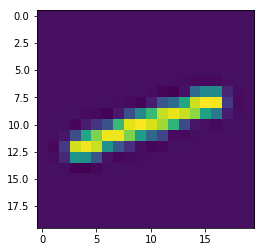

In [107]:
#test prediction
random_digit = np.random.randint(m)
predicted = 0 if pred[random_digit] == 10 else pred[random_digit]
print(f"Prediction: {predicted}")
plt.imshow(X[random_digit].reshape((20, 20)))
plt.show()